In [1]:
%load_ext autoreload
%autoreload 2

import time
import random
import pickle, os
import numpy as np
import cvxpy as cp

from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

from free_flyer.free_flyer import FreeFlyer
from free_flyer.utils import *
from solvers.coco_ff import CoCo_FF
from solvers.meta_ff import Meta_FF

In [2]:
#load train/test data
prob = FreeFlyer() #use default config, pass different config file oth.
config_fn = './free_flyer/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
# p_train, x_train, u_train, y_train, c_train, times_train = pickle.load(train_file)
train_data = pickle.load(train_file)
train_file.close()
x_train = train_data[1]
y_train = train_data[3]

test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, c_test, times_test = test_data
test_file.close()

n_test = x_test.shape[0]

In [3]:
train_data[0]['x0'].shape
n_train = 10000

for kk in train_data[0].keys():
    train_data[0][kk] = train_data[0][kk][:n_train] 
train_data[0]['obstacles'].shape

(10000, 4, 8)

In [4]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles_map']

meta_learner = Meta_FF(system, prob, prob_features)

n_features = 4
device_id= -1
meta_learner.construct_strategies(n_features, train_data, device_id=device_id)

In [5]:
coco_model_fn = 'models/CoCoFF_free_flyer_20210406_0808.pt'
feas_model_fn = 'None'

# Meta-CoCoFF trained on 10K data points (free_flyer_parsimonious)
coco_model_fn = 'MetaCoCoFF_free_flyer_20210428_2318.pt'
feas_model_fn = 'MetaCoCoFF_feas_free_flyer_20210428_2318.pt'

# # Vanilla CoCoFF trained on 10K data points (no meta step) (free_flyer_no_meta)
# coco_model_fn = 'MetaCoCoFF_free_flyer_20210502_1528.pt'
# feas_model_fn = 'MetaCoCoFF_feas_free_flyer_20210502_1528.pt'

override_model_fn = False
meta_learner.load_network(coco_model_fn, override_model_fn, feas_model_fn=feas_model_fn)

meta_learner.model_fn

Loading presaved classifier model from MetaCoCoFF_free_flyer_20210428_2318.pt
Loading presaved feasibility model from MetaCoCoFF_feas_free_flyer_20210428_2318.pt


'/home/acauligi/cs_234/project/mlopt-micp/MetaCoCoFF_free_flyer_20210504_1631.pt'

In [ ]:
meta_learner.training_params['CHECKPOINT_AFTER'] = int(50)
meta_learner.training_params['SAVEPOINT_AFTER'] = int(100)

meta_learner.update_lr = 1e-5
meta_learner.update_step = 0

meta_learner.train(train_data, "runs/free_flyer_no_meta")
# meta_learner.finetuning(test_data, "runs/finetunning")

In [ ]:
successes = []
for itr in range(200):
    prob_params_list = []
    for _ in range(10):
        ii = np.random.randint(0,n_test)
        prob_params = {}
        for k in p_test.keys():
            prob_params[k] = p_test[k][ii]
        prob_params_list.append(prob_params)
    prob_successes = meta_learner.forward(prob_params_list)[0]
    successes.append(np.sum(prob_successes) / float(len(prob_successes)))
    if itr % 5 == 0:
        print('Done with iteration {}: {}\n'.format(itr, successes[-1]))

Done with iteration 0: 0.6



In [ ]:
len(prob_params_list)

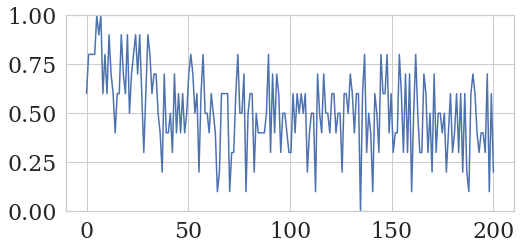

In [9]:
import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd
import h5py
import matplotlib

plt.figure(figsize=(8,4))
plt.ylim(0,1)
plt.tight_layout()

time = np.linspace(0,len(successes),len(successes))
ax1 = sns.lineplot(time, successes, palette="Set 3")

figure = ax1.get_figure()
figure.savefig("coconut_plot.png", bbox_inches='tight')

In [8]:
meta_learner